In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import holidays
import time
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#load training/testing data
train_data = pd.read_csv("train.csv", index_col=[1], parse_dates=[1])
train_data = train_data.drop(['id'], axis=1)
#train_data

test_data = pd.read_csv("test.csv", index_col=[1], parse_dates=[1])
test_data = test_data.drop(['id'], axis=1)
#test_data

In [3]:
#summary statistics of dataset
train_data["speed"].describe()

count    14006.000000
mean        32.779118
std         13.573813
min          2.573417
25%         19.301089
50%         36.580595
75%         45.877665
max         53.161286
Name: speed, dtype: float64

In [4]:
#check if there is any missing values of train_data
train_data.isnull().sum(axis = 0)

speed    0
dtype: int64

In [5]:
train_data.head()

,speed
date,
2017-01-01 00:00:00,43.002930
2017-01-01 01:00:00,46.118696
2017-01-01 02:00:00,44.294158
2017-01-01 03:00:00,41.067468
2017-01-01 04:00:00,46.448653


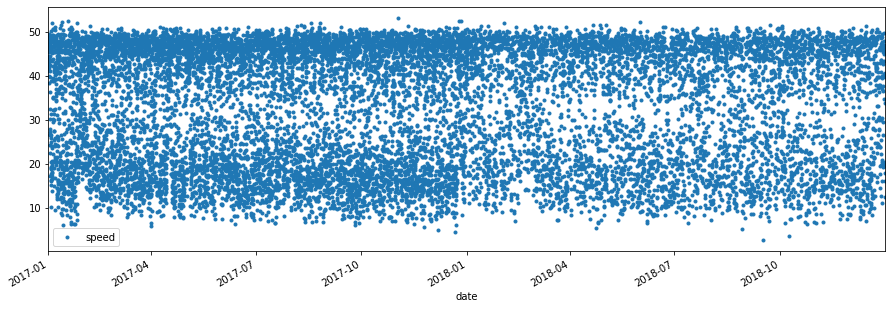

In [6]:
train_data.plot(style='.', figsize=(15,5))
plt.show()

In [7]:
# extract detailed data information from train_data

def create_features(df, label=None):
    df['date'] = df.index
    df['timestamp'] = df['date'].apply(lambda x: time.mktime(x.timetuple()))
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear 
    df['holiday'] = df['date']\
        .apply(lambda x: 1 if x.date() in holidays.HongKong(years=[2017, 2018]).keys() else 0)
    
    X = df[['timestamp','hour','dayofweek','quarter','month',\
            'year','dayofyear','dayofmonth','weekofyear','holiday']] 
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X, y = create_features(train_data, label='speed')

In [9]:
X

,timestamp,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
date,,,,,,,,,,
2017-01-01 00:00:00,1.483200e+09,0,6,1,1,2017,1,1,52,0
2017-01-01 01:00:00,1.483204e+09,1,6,1,1,2017,1,1,52,0
2017-01-01 02:00:00,1.483207e+09,2,6,1,1,2017,1,1,52,0
2017-01-01 03:00:00,1.483211e+09,3,6,1,1,2017,1,1,52,0
2017-01-01 04:00:00,1.483214e+09,4,6,1,1,2017,1,1,52,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 12:00:00,1.546229e+09,12,0,4,12,2018,365,31,1,0
2018-12-31 15:00:00,1.546240e+09,15,0,4,12,2018,365,31,1,0
2018-12-31 16:00:00,1.546243e+09,16,0,4,12,2018,365,31,1,0


In [10]:
y

date
2017-01-01 00:00:00    43.002930
2017-01-01 01:00:00    46.118696
2017-01-01 02:00:00    44.294158
2017-01-01 03:00:00    41.067468
2017-01-01 04:00:00    46.448653
                         ...    
2018-12-31 12:00:00    19.865269
2018-12-31 15:00:00    17.820375
2018-12-31 16:00:00    12.501851
2018-12-31 18:00:00    15.979319
2018-12-31 20:00:00    40.594183
Name: speed, Length: 14006, dtype: float64

In [11]:
# split train_data 80/20 into train set and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
# use xgboost model to fit training data
model = xgb.XGBRegressor()
model.fit(X_train, y_train, verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
# get the predictions
y_train_predict = model.predict(X_train)
y_valid_predict = model.predict(X_valid)

# calculate MSE of both train set and valid set
print("MSE of Train Set: {0}".format(mean_squared_error(y_train, y_train_predict)))
print("MSE of Valid Set: {0}".format(mean_squared_error(y_valid, y_valid_predict)))

MSE of Train Set: 8.990859317405699
MSE of Valid Set: 15.572955685004873


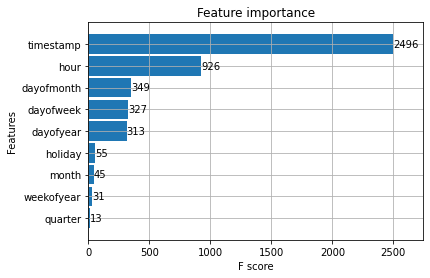

In [15]:
#visualize the most important factors
plot_importance(model, height=0.9)
plt.show()

In [16]:
# tuning parameters
params = {'n_estimators':[1000, 1500], 'learning_rate':[0.01, 0.02, 0.05]}
model = xgb.XGBRegressor(max_depth=10,
                         subsample=0.8,
                         min_child_weight=1,
                         random_state=5,
                         reg_alpha=0,
                         reg_lambda=1)

grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=8)
grid.fit(X_train, y_train)
print('Best Parameters：{0}'.format(grid.best_params_))
print('Best Score:{0}'.format(grid.best_score_))

Best Parameters：{'learning_rate': 0.02, 'n_estimators': 1500}
Best Score:-15.1050985854537


In [17]:
# re-build model by using GridSearch parameters
model = xgb.XGBRegressor(max_depth=10,
                         subsample=0.8,
                         n_estimators=1500,
                         learning_rate=0.02,
                         min_child_weight=1,
                         random_state=5,
                         reg_alpha=0,
                         reg_lambda=1)

model.fit(X_train, y_train, verbose=False) 

# get the updated predictions
y_train_predict = model.predict(X_train)
y_valid_predict = model.predict(X_valid)

# calculate MSE of both train set and valid set
print("MSE of Train Set: {0}".format(mean_squared_error(y_train, y_train_predict)))
print("MSE of Valid Set: {0}".format(mean_squared_error(y_valid, y_valid_predict)))

MSE of Train Set: 1.3230296898082592
MSE of Valid Set: 13.12373164531311


In [18]:
# extract detailed data information from test_data
X_test = create_features(test_data, label=None)

In [19]:
X_test

,timestamp,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
date,,,,,,,,,,
2018-01-01 02:00:00,1.514743e+09,2,0,1,1,2018,1,1,1,1
2018-01-01 05:00:00,1.514754e+09,5,0,1,1,2018,1,1,1,1
2018-01-01 07:00:00,1.514761e+09,7,0,1,1,2018,1,1,1,1
2018-01-01 08:00:00,1.514765e+09,8,0,1,1,2018,1,1,1,1
2018-01-01 10:00:00,1.514772e+09,10,0,1,1,2018,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 17:00:00,1.546247e+09,17,0,4,12,2018,365,31,1,0
2018-12-31 19:00:00,1.546254e+09,19,0,4,12,2018,365,31,1,0
2018-12-31 21:00:00,1.546261e+09,21,0,4,12,2018,365,31,1,0


In [20]:
# get predictions for test_data
y_test = model.predict(X_test)
y_test

array([48.460835, 48.06642 , 35.347206, ..., 45.510506, 40.24821 ,
       40.86981 ], dtype=float32)

In [23]:
submission = pd.read_csv("sampleSubmission.csv")
submission['speed'] = y_test
submission.to_csv('final_result.csv',index=False)